
Bus Voltages:
------------------------------------------------------------
Bus Name             Voltage (pu)    Angle (deg)    
------------------------------------------------------------
bus1                  1.0000         -0.00          
bus2                  1.0000         -0.00          
bus3                  0.9980         -30.24         
bus4                  0.9980         -30.23         
bus5                  0.9148         -30.77         
bus6                  0.9149         -30.77         

Power Flows:
---------------------------------------------------------------------------
Element              Power (kW)      Power (kVAR)    Current             
---------------------------------------------------------------------------
Transformer.transformer1  10.05           3.45            1.67   ∠-18.96  °
Transformer.transformer2  10.04           3.45            1.67   ∠-18.97  °
Line.lv_line1         10.05           3.41            46.03  ∠-48.96  °
Line.lv_line2         10.04 

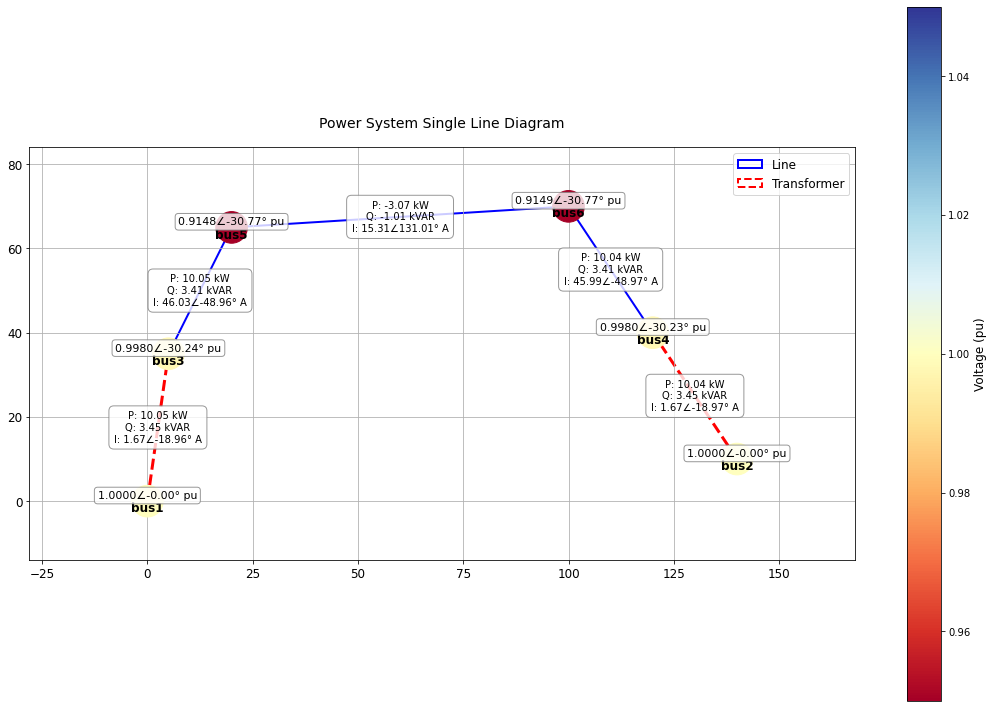

In [3]:

import opendssdirect as dss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Circle, Patch
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 12

main_path = r"C:\Users\47939\Desktop\Interviews\KTP\Technical_Task_KTP"



#Init OpenDSS
def load_network(main_path):
    """Load network coordinates and initialize OpenDSS"""

    coordinates_df = pd.read_csv(
        f"{main_path}\\Network_coordinate.csv",
        delimiter=',',
        names=['Bus', 'X', 'Y']
    )

    bus_coord_dict = {
        bus.lower(): (float(x), float(y))
        for bus, x, y in zip(coordinates_df.Bus, coordinates_df.X, coordinates_df.Y)
    }


    dss.Basic.DataPath(main_path)
    dss.Text.Command(f'Compile {main_path}\\PF_SnapMode.dss')


    dss.Text.Command('set mode=sanp')
#     dss.Text.Command('set stepsize=1h')
    dss.Text.Command('solve')

    return bus_coord_dict
        


# Network Graph Creation
def create_network_graph(bus_coordinates):
    """Create network graph with voltage and power flow information"""
    G = nx.Graph()
    positions = {}
    
    # Add buses 
    for bus in dss.Circuit.AllBusNames():
        if bus.lower() == 'sourcebus':
            continue
            
        base_bus = bus.split('.')[0].lower()
        if base_bus in bus_coordinates:
            x, y = bus_coordinates[base_bus]
            
            # Get voltage
            dss.Circuit.SetActiveBus(bus)
            v_pu = dss.Bus.puVmagAngle()[0]
            v_ang = dss.Bus.puVmagAngle()[1]
            
            G.add_node(bus, voltage_pu=v_pu, voltage_ang=v_ang, type='bus')
            positions[bus] = (x, y)
    

    for elem in dss.Circuit.AllElementNames():
        dss.Circuit.SetActiveElement(elem)
        bus_names = dss.CktElement.BusNames()
        
        if len(bus_names) >= 2:
            from_bus, to_bus = bus_names[0], bus_names[1]
            
            if ('sourcebus' not in from_bus.lower() and
                'sourcebus' not in to_bus.lower() and
                from_bus in positions and
                to_bus in positions):
                
                # Get power flow
                powers = dss.CktElement.Powers()
                currents = dss.CktElement.Currents()
                
                if len(powers) >= 2 and len(currents) >= 2:
                    # Calculate current magnitude and angle
                    current_mag = np.sqrt(currents[0]**2 + currents[1]**2)
                    current_ang = np.degrees(np.arctan2(currents[1], currents[0]))
                    
                    G.add_edge(
                        from_bus, to_bus,
                        name=elem,
                        type='line' if elem.lower().startswith('line') else 'transformer',
                        p_kw=powers[0],
                        q_kvar=powers[1],
                        current_mag=current_mag,
                        current_ang=current_ang
                    )
    
    return G, positions

# Network Visualization
def draw_network(G, bus_positions, show_current=False):
    """Draw network diagram with voltage and power/current flow information"""
    fig, ax = plt.subplots(figsize=(15, 10))
    
    voltage_values = [G.nodes[node]['voltage_pu'] for node in G.nodes()]
    
    scatter = ax.scatter(
        [pos[0] for pos in bus_positions.values()],
        [pos[1] for pos in bus_positions.values()],
        c=voltage_values,
        s=1000,
        cmap=plt.cm.RdYlBu,
        vmin=0.95,
        vmax=1.05,
        zorder=2
    )
    

    for u, v, data in G.edges(data=True):
        x1, y1 = bus_positions[u]
        x2, y2 = bus_positions[v]
        
        if data['type'] == 'line':
            ax.plot([x1, x2], [y1, y2], 'b-', linewidth=2, zorder=1)
        else:  # transformer
            ax.plot([x1, x2], [y1, y2], 'r--', linewidth=3, zorder=1)
        

        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2
        
        label = f"P: {data['p_kw']:.2f} kW\nQ: {data['q_kvar']:.2f} kVAR"
        if show_current:
            label += f"\nI: {data['current_mag']:.2f}∠{data['current_ang']:.2f}° A"
            
        bbox_props = dict(
            boxstyle="round,pad=0.5",
            fc="white",
            ec="gray",
            alpha=0.8
        )
        
        ax.text(
            mid_x, mid_y,
            label,
            ha='center',
            va='center',
            fontsize=10,
            bbox=bbox_props,
            zorder=3
        )
    

    for bus, pos in bus_positions.items():
        # Bus name
        ax.text(
            pos[0], pos[1]-0.15,
            bus,
            ha='center',
            va='top',
            fontsize=12,
            fontweight='bold'
        )
        
      
        voltage = G.nodes[bus]['voltage_pu']
        v_ang = G.nodes[bus]['voltage_ang']
        voltage_label = f'{voltage:.4f}∠{v_ang:.2f}° pu'
        
        voltage_bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="gray",
            alpha=0.8
        )
        
        ax.text(
            pos[0], pos[1]+0.15,
            voltage_label,
            ha='center',
            va='bottom',
            fontsize=11,
            bbox=voltage_bbox_props,
            zorder=3
        )
    

    cbar = plt.colorbar(scatter, label='Voltage (pu)')
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_ylabel('Voltage (pu)', fontsize=12)
    
    legend_elements = [
        Patch(facecolor='none', edgecolor='blue', linewidth=2, label='Line'),
        Patch(facecolor='none', edgecolor='red', linestyle='--', linewidth=2, label='Transformer')
    ]
    ax.legend(
        handles=legend_elements,
        fontsize=12,
        loc='upper right',
    
    )
    
    plt.title('Power System Single Line Diagram', fontsize=14, pad=20)
    ax.set_aspect('equal')
    plt.grid(True)
    
  
    plt.margins(0.2)
    plt.tight_layout()
    
    return fig, ax

#  Print Results
def print_network_results(G):
    """Print summary of network results"""
    print("\nBus Voltages:")
    print("-" * 60)
    print(f"{'Bus Name':<20} {'Voltage (pu)':<15} {'Angle (deg)':<15}")
    print("-" * 60)
    for node in G.nodes():
        v_pu = G.nodes[node]['voltage_pu']
        v_ang = G.nodes[node]['voltage_ang']
        print(f"{node:<20} {v_pu:< 15.4f} {v_ang:< 15.2f}")
    
    print("\nPower Flows:")
    print("-" * 75)
    print(f"{'Element':<20} {'Power (kW)':<15} {'Power (kVAR)':<15} {'Current':<20}")
    print("-" * 75)
    for u, v, d in G.edges(data=True):
        print(f"{d['name']:<20} {d['p_kw']:< 15.2f} {d['q_kvar']:< 15.2f} {d['current_mag']:< 8.2f}∠{d['current_ang']:< 8.2f}°")

#
# Load network
bus_coord_dict = load_network(main_path)

# Create and draw network
G, bus_positions = create_network_graph(bus_coord_dict)
fig, ax = draw_network(G, bus_positions, show_current=True)

# Print results
print_network_results(G)